# Xradar Demo

- Author: Hamid Ali Syed
- Purpose: For Khairunnisa
- Date: Nov 1, 2023

In [3]:
import xradar
print(xradar.__version__)
import cmweather

0.4.0


## PPI

In [4]:
file1 = "2021110309550500dBZ.vol"

In [5]:
vol = xradar.io.open_rainbow_datatree(file1)

In [6]:
vol

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2021-11-03T09:55:05Z'
│       time_coverage_end    <U20 '2021-11-03T09:59:41Z'
│       longitude            float64 101.7
│       altitude             float64 119.0
│       latitude             float64 2.847
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5273 1.533 2.527 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 250.0 750.0 ... 4.792e+05 4.798e+05
│           time               (azimuth) datetime64[ns] 2021-11-03T09:55:07.843750 .....
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5054 1.516 2.508 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           time               (azimuth) datetime64[ns] 2021-11-03T09:55:56.464285500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5219 1.522 2.505 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           time               (azimuth) datetime64[ns] 2021-11-03T09:56:16.916666499...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5081 1.522 2.521 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           time               (azimuth) datetime64[ns] 2021-11-03T09:56:36.472222 .....
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 .

In [7]:
vol = vol.xradar.georeference()
display(vol)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2021-11-03T09:55:05Z'
│       time_coverage_end    <U20 '2021-11-03T09:59:41Z'
│       longitude            float64 101.7
│       altitude             float64 119.0
│       latitude             float64 2.847
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5273 1.533 2.527 ... 358.5 359.5
│           elevation          (azimuth) float64 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7
│         * range              (range) float32 250.0 750.0 ... 4.792e+05 4.798e+05
│           time               (azimuth) datetime64[ns] 2021-11-03T09:55:07.843750 .....
│           longitude          float64 101.7
│           latitude           float64 2.847
│           altitude           float64 119.0
│           crs_wkt            int64 0
│           x                  (azimuth, range) float64 2.301 6.902 ... -3.948e+03
│           y                  (azimuth, range) float64 250.0 749.9 ... 4.789e+05
│           z                  (azimuth, range) float64 122.1 128.2 ... 1.949e+04
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5054 1.516 2.508 ... 358.5 359.5
│           elevation          (azimuth) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           time               (azimuth) datetime64[ns] 2021-11-03T09:55:56.464285500...
│           longitude          float64 101.7
│           latitude           float64 2.847
│           altitude           float64 119.0
│           crs_wkt            int64 0
│           x                  (azimuth, range) float64 1.102 3.307 ... -2.045e+03
│           y                  (azimuth, range) float64 125.0 374.9 ... 2.396e+05
│           z                  (azimuth, range) float64 121.2 125.6 ... 7.685e+03
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5219 1.522 2.505 ... 358.5 359.5
│           elevation          (azimuth) float64 1.5 1.5 1.5 1.5 1.5 ... 1.5 1.5 1.5 1.5
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           time               (azimuth) datetime64[ns] 2021-11-03T09:56:16.916666499...
│           longitude          float64 101.7
│           latitude           float64 2.847
│           altitude           float64 119.0
│           crs_wkt            int64 0
│           x                  (azimuth, range) float64 1.138 3.414 ... -2.01e+03
│           y                  (azimuth, range) float64 125.0 374.9 ... 2.395e+05
│           z                  (azimuth, range) float64 122.3 128.8 ... 9.776e+03
│       Data variables:
│           DBZH           

In [8]:
vol.groups

('/',
 '/sweep_0',
 '/sweep_1',
 '/sweep_2',
 '/sweep_3',
 '/sweep_4',
 '/sweep_5',
 '/sweep_6',
 '/sweep_7',
 '/sweep_8',
 '/sweep_9',
 '/sweep_10',
 '/sweep_11',
 '/sweep_12')

In [9]:
vol.sweep_0

DataTree('sweep_0', parent="root")
    Dimensions:            (azimuth: 360, range: 960)
    Coordinates:
      * azimuth            (azimuth) float64 0.5273 1.533 2.527 ... 358.5 359.5
        elevation          (azimuth) float64 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7
      * range              (range) float32 250.0 750.0 ... 4.792e+05 4.798e+05
        time               (azimuth) datetime64[ns] 2021-11-03T09:55:07.843750 .....
        longitude          float64 101.7
        latitude           float64 2.847
        altitude           float64 119.0
        crs_wkt            int64 0
        x                  (azimuth, range) float64 2.301 6.902 ... -3.948e+03
        y                  (azimuth, range) float64 250.0 749.9 ... 4.789e+05
        z                  (azimuth, range) float64 122.1 128.2 ... 1.949e+04
    Data variables:
        DBZH               (azimuth, range) float32 ...
        sweep_mode         <U20 ...
        sweep_number       int64 ...
        prt_mode           <U7 ...
        follow_mode        <U7 ...
        sweep_fixed_angle  float64 ...

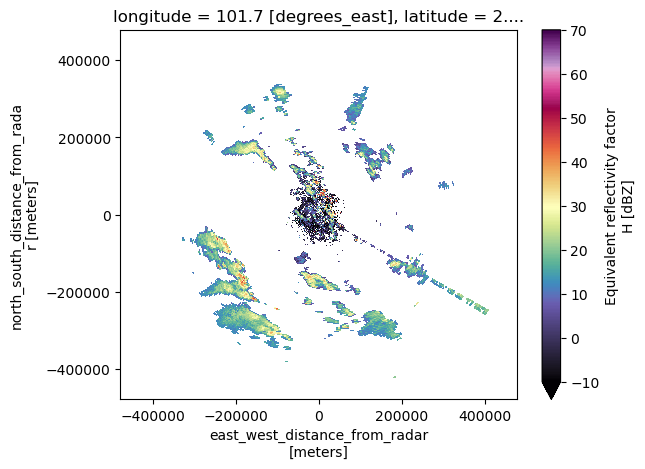

In [10]:
vol["sweep_0"]["DBZH"].plot(x="x",
                             y="y",
                             cmap="ChaseSpectral",
                             vmin=-10, vmax=70
                            )

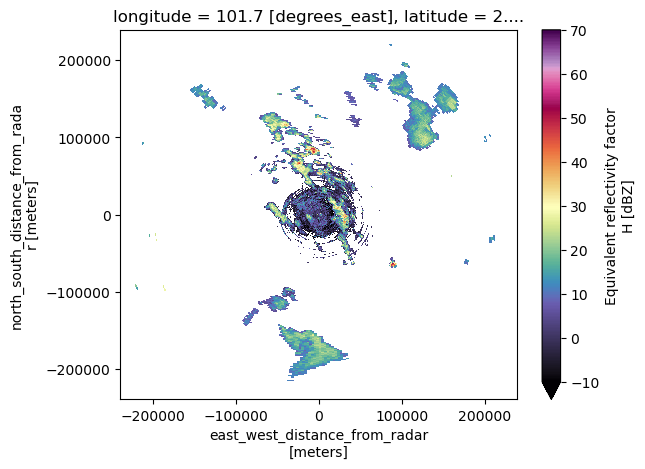

In [11]:
vol["sweep_3"]["DBZH"].plot(x="x",
                             y="y",
                             cmap="ChaseSpectral",
                             vmin=-10, vmax=70
                            )

In [12]:
file2 = "2021110312350500dBZ.vol"

In [13]:
vol2 = xradar.io.open_rainbow_datatree(file2)

In [14]:
vol2.groups

('/',
 '/sweep_0',
 '/sweep_1',
 '/sweep_2',
 '/sweep_3',
 '/sweep_4',
 '/sweep_5',
 '/sweep_6',
 '/sweep_7',
 '/sweep_8',
 '/sweep_9',
 '/sweep_10',
 '/sweep_11',
 '/sweep_12')

In [15]:
vol2 = vol2.xradar.georeference()
display(vol2.sweep_0)

DataTree('sweep_0', parent="root")
    Dimensions:            (azimuth: 360, range: 960)
    Coordinates:
      * azimuth            (azimuth) float64 0.5301 1.522 2.513 ... 358.5 359.5
        elevation          (azimuth) float64 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7
      * range              (range) float32 250.0 750.0 ... 4.792e+05 4.798e+05
        time               (azimuth) datetime64[ns] 2021-11-03T12:35:11.906250 .....
        longitude          float64 101.7
        latitude           float64 2.847
        altitude           float64 119.0
        crs_wkt            int64 0
        x                  (azimuth, range) float64 2.313 6.938 ... -4.04e+03
        y                  (azimuth, range) float64 250.0 749.9 ... 4.789e+05
        z                  (azimuth, range) float64 122.1 128.2 ... 1.949e+04
    Data variables:
        DBZH               (azimuth, range) float32 ...
        sweep_mode         <U20 ...
        sweep_number       int64 ...
        prt_mode           <U7 ...
        follow_mode        <U7 ...
        sweep_fixed_angle  float64 ...

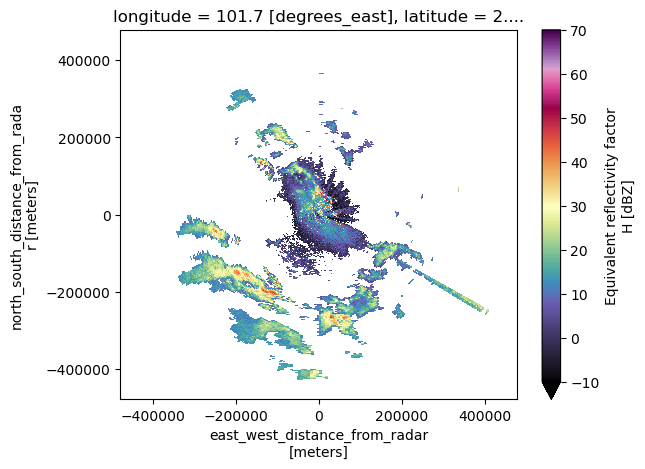

In [16]:
vol2["sweep_0"]["DBZH"].plot(x="x",
                             y="y",
                             cmap="ChaseSpectral",
                             vmin=-10, vmax=70
                            )